# Exercise 2: Optimize _hls4ml_ Conversion
Optimizing the conversion of a Neural Network into firmware is always a trade-off between how many resources we can occupy on the hardware, how fast we want our algorithm to run and how accurate we want the performance to be.

In this exercise we will explore a few options to control how _hls4ml_ translates the Neural Network into a firmware.

## Objectives
In this exercise, you will:
1. Explore different ways of optimizing the _hls4ml_ conversion
2. Compare the optimized models

## Instructions
Complete the code cells marked with `# TODO` comments. Follow the hints provided.

## Part 1: Environment Setup and Data Loading
Run the following cells to set up the environment (no changes needed).

In [1]:
# Load libraries and import packages (no changes needed)

# General imports
import os

# Numpy and plotting
import numpy as np
import matplotlib.pyplot as plt

# TimeSeries to hold our data
from gwpy.timeseries import TimeSeries

# Keras, numpy and matplotlib
from keras.models import load_model

# Local file with some useful methods
from utils import *

# hls4ml
import hls4ml
from hls4ml.model.profiling import numerical, get_ymodel_keras

# Set the correct libraries path for hls4ml
os.environ['XILINX_HLS']    = '/opt/tools/Xilinx/Vitis_HLS/2023.2'
os.environ['XILINX_VIVADO'] = '/opt/tools/Xilinx/Vivado/2023.2'
os.environ['XILINX_VITIS']  = '/opt/tools/Xilinx/Vitis/2023.2'
os.environ['PATH'] = os.environ["PATH"] + ":" \
                   + os.environ['XILINX_HLS'] + "/bin:" \
                   + os.environ['XILINX_VIVADO'] + "/bin:" \
                   + os.environ['XILINX_VITIS'] + "/bin:"

print("Environment setup correctly!")

2025-11-22 21:02:56.684664: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-22 21:02:56.687024: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-22 21:02:56.719373: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-22 21:02:56.719440: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-22 21:02:56.719465: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Environment setup correctly!


Load the model and the test data

In [2]:
# Load the encoder model previously trained
model = load_model('small_model/small_encoder.keras')

# Load the test data previously saved
X_test = np.load("X_test.npy")
print(f"Loaded {X_test.shape[0]} test data with shape {X_test[0].shape}")

# Make sure the output directory to store plots and results exists:
if not os.path.exists('inference'):
    os.makedirs('inference')

Loaded 2000 test data with shape (64, 1)


## Part 2: Optimization

### Task 2.1: Precision
You can control how the model parameters are implemented (bit-representation) via the `Precision` parameter in the `hls_config`.

In [3]:
# Define a config with a custom precision and explore its performance

# Define a default hls config
precision_config = hls4ml.utils.config_from_keras_model(model, granularity='model')

# Change the Model precision
precision_config['Model']['Precision'] = 'ap_fixed<6,3>'

Once done, include it in the main config as usual:

In [4]:
# Define the HLS model

# Main config
main_cfg = hls4ml.converters.create_config(
    board = 'alveo-u55c',            # Target boad and FPGA part
    part = 'xcu55c-fsvh2892-2L-e',   #
    clock_period = 3,                # Clock period in ns -> 3 ns = ~333 MHz
    backend = 'VivadoAccelerator'    # Backend to convert NN -> firmware
)

# Few more customizations
# YOUR CODE HERE
main_cfg['HLSConfig'] = precision_config
main_cfg['IOType'] = 'io_parallel'
main_cfg['AcceleratorConfig']['Platform'] = 'xilinx_u55c_gen3x16_xdma_3_202210_1'
main_cfg['KerasModel'] = model
main_cfg['OutputDir'] = "small_model/small_encoder_precision"

print("="*20, "Main Config", "="*20)
print_dict(main_cfg)
print("="*50)

# Define the hls model
precision_model = hls4ml.converters.keras_v2_to_hls(main_cfg)

# Compile it
precision_model.compile()

==================== Main Config ====================
OutputDir:           small_model/small_encoder_precision
ProjectName:         myproject
Backend:             VivadoAccelerator
Version:             1.0.0
Part:                xcu55c-fsvh2892-2L-e
ClockPeriod:         3
ClockUncertainty:    12.5%
IOType:              io_parallel
HLSConfig
  Model
    Precision:       ap_fixed<6,3>
    ReuseFactor:     1
    Strategy:        Latency
    BramFactor:      1000000000
    TraceOutput:     False
WriterConfig
  Namespace:         None
  WriteWeightsTxt:   True
  WriteTar:          False
  TBOutputStream:    both
AcceleratorConfig
  Board:             alveo-u55c
  Interface:         axi_stream
  Driver:            python
  Precision
    Input:           float
    Output:          float
  Platform:          xilinx_u55c_gen3x16_xdma_3_202210_1
KerasModel:          <keras.src.engine.sequential.Sequential object at 0x7ff23ade7520>


You can now run inference with this updated HLS model

In [5]:
# Run inference
y_precision = precision_model.predict(X_test)

# Save predictions for later comparisons
np.save('y_precision.npy', y_precision)
print("Precision config predictions saved as 'y_precision.npy'.")

Precision config predictions saved as 'y_precision.npy'.


and compare its performance with the keras model:


=== Software vs Precision Reconstruction Metrics ===
Overall MSE           : 0.950521
Average MSE per sample: 0.950521
Min MSE               : 0.300349
Max MSE               : 1.611419
Mean Absolute Error   : 0.816186
RMSE                  : 0.974947

Comparison plot saved as 'cpu_hls_precision_comparison.png'
Error distribution plot saved as 'precision_error_distribution.png'


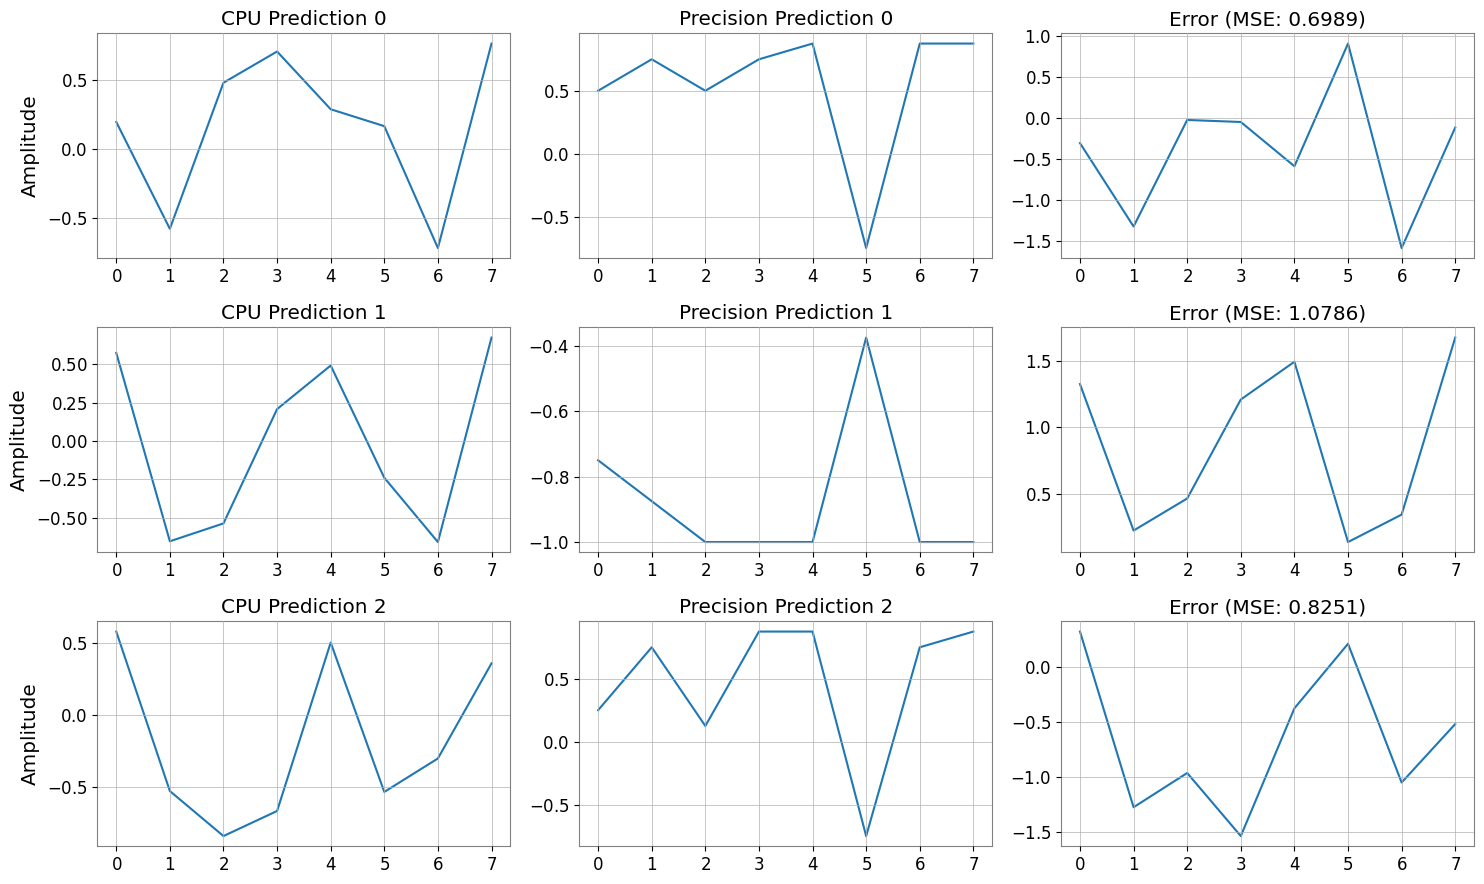

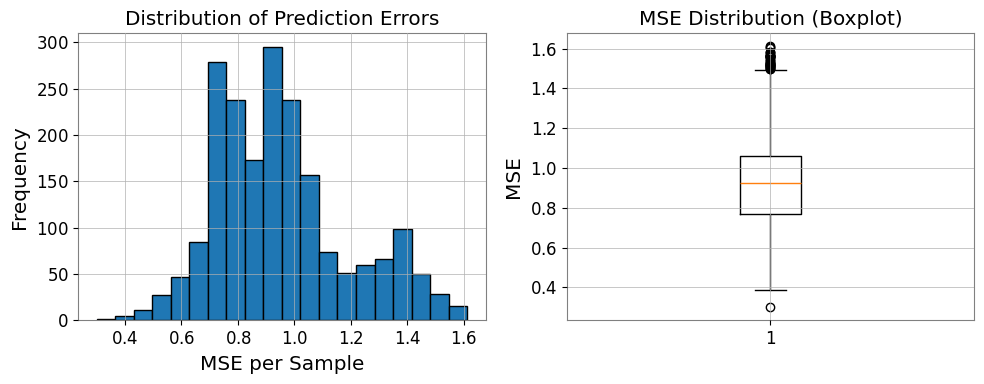

In [6]:
# Calculate and visualize comparison metrics

# Load the previously saved inferences
y_cpu = np.load("y_cpu.npy")

# MSE per sample: mean squared error for each sample across all features
mse_per_sample = np.mean((y_cpu - y_precision)**2, axis=1)

# Overall MSE: average of all MSE values
overall_mse = np.mean(mse_per_sample)

# MAE: mean absolute error across all predictions
mae = np.mean(np.abs(y_cpu - y_precision))

# RMSE: square root of overall MSE
rmse = np.sqrt(overall_mse)

# Print the metrics
print(f"\n=== Software vs Precision Reconstruction Metrics ===")
print(f"Overall MSE           : {overall_mse:.6f}")
print(f"Average MSE per sample: {np.mean(mse_per_sample):.6f}")
print(f"Min MSE               : {np.min(mse_per_sample):.6f}")
print(f"Max MSE               : {np.max(mse_per_sample):.6f}")
print(f"Mean Absolute Error   : {mae:.6f}")
print(f"RMSE                  : {rmse:.6f}")

# Visualize comparison for first 3 samples (no changes needed)
n_examples = 3
fig, axes = plt.subplots(n_examples, 3, figsize=(15, 3*n_examples))

for i in range(n_examples):
    # CPU predictions
    axes[i, 0].plot(y_cpu[i])
    axes[i, 0].set_title(f'CPU Prediction {i}')
    axes[i, 0].set_ylabel('Amplitude')
    axes[i, 0].grid(True)
    
    # HLS predictions
    axes[i, 1].plot(y_precision[i])
    axes[i, 1].set_title(f'Precision Prediction {i}')
    axes[i, 1].grid(True)
    
    # Difference
    axes[i, 2].plot(y_cpu[i] - y_precision[i])
    axes[i, 2].set_title(f'Error (MSE: {mse_per_sample[i]:.4f})')
    axes[i, 2].grid(True)

plt.tight_layout()
plt.savefig('cpu_hls_comparison.png')
print("\nComparison plot saved as 'cpu_hls_precision_comparison.png'")

# Visualize error distribution (no changes needed)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(mse_per_sample, bins=20, edgecolor='black')
plt.xlabel('MSE per Sample')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot(mse_per_sample)
plt.ylabel('MSE')
plt.title('MSE Distribution (Boxplot)')
plt.grid(True)

plt.tight_layout()
plt.savefig('precision_error_distribution.png')
print("Error distribution plot saved as 'precision_error_distribution.png'")

**Questions**
1. How does the new model compare with the keras model?
2. How does the new model compare with the previous HLS config?
3. Is this what you expected based on the Precision chosen?

### Task 2.2: Profiling
When the `granularity` parameter of the config is set to `name`, _hls4ml_ allows to finely control the bit representation of all the outputs, biases and weights for each layer singularly.

By default all values is set to `auto`, which is an overly-conservative value chosen in order to avoid overflow and truncation issues.
We can profit of the _hls4ml_ "Profiling" method to manually adjust the configuration and explicitly set the specific widths.

Let's define and explore a config with `name` granularity:

In [7]:
# Define an hls config with "name" granularity (no changes needed)
profiling_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

print("="*20, "Profiling Config", "="*20)
print_dict(profiling_config)
print("="*50)

==================== Profiling Config ====================
Model
  Precision
    default:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
LayerName
  flatten_input
    Trace:           False
    Precision
      result:        auto
  flatten
    Trace:           False
    Precision
      result:        auto
  encoder1
    Trace:           False
    Precision
      result:        auto
      weight:        auto
      bias:          auto
  encoder1_tanh
    Trace:           False
    Precision
      result:        auto
  encoder2
    Trace:           False
    Precision
      result:        auto
      weight:        auto
      bias:          auto
  encoder2_tanh
    Trace:           False
    Precision
      result:        auto
  encoder3
    Trace:           False
    Precision
      result:        auto
      weight:        auto
      bias:          auto
  encoder3_tanh
    Trace:           False
    Precis

We can now use the "Profiling" tool to explore how well our hls model bit-representation actually "covers" the model parameters:

> This method plots the distribution of the weights (and biases) as a box and whisker plot. The grey boxes show the values which can be represented with the data types used in the hls_model. Generally, you need the box to overlap completely with the whisker ‘to the right’ (large values) otherwise you’ll get saturation & wrap-around issues. It can be okay for the box not to overlap completely ‘to the left’ (small values), but finding how small you can go is a matter of trial-and-error.

Profiling weights (before optimization)
[{'med': 0.09697801, 'q1': 0.04843846149742603, 'q3': 0.1486123502254486, 'whislo': 3.562207e-06, 'whishi': 0.27008936, 'layer': 'encoder1', 'weight': 'encoder1/w'}, {'med': 7.702223e-06, 'q1': 3.994020062236814e-06, 'q3': 1.5192467799352016e-05, 'whislo': 8.657662e-08, 'whishi': 4.55232e-05, 'layer': 'encoder1', 'weight': 'encoder1/b'}, {'med': 0.0987, 'q1': 0.04953202232718468, 'q3': 0.1521456018090248, 'whislo': 0.00014057058, 'whishi': 0.31900853, 'layer': 'encoder2', 'weight': 'encoder2/w'}, {'med': 7.1260674e-06, 'q1': 3.2685759379091905e-06, 'q3': 1.1987546258751536e-05, 'whislo': 7.679387e-07, 'whishi': 2.417443e-05, 'layer': 'encoder2', 'weight': 'encoder2/b'}, {'med': 0.113650665, 'q1': 0.06062371749430895, 'q3': 0.1793503500521183, 'whislo': 0.00024497058, 'whishi': 0.44388136, 'layer': 'encoder3', 'weight': 'encoder3/w'}, {'med': 9.981599e-06, 'q1': 4.275195124137099e-06, 'q3': 1.2130156846978934e-05, 'whislo': 3.6675135e-07, 'whishi'

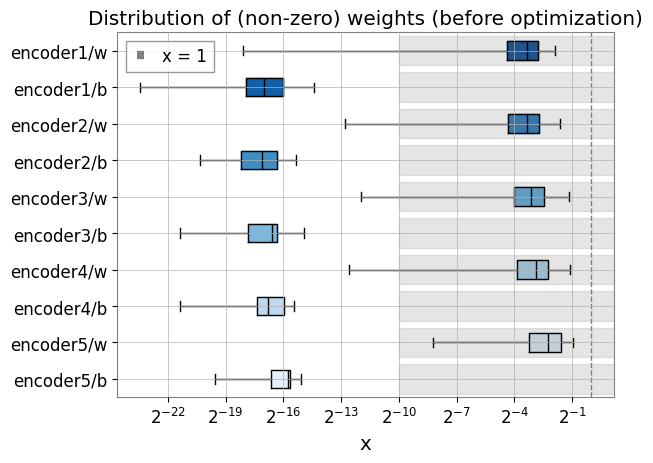

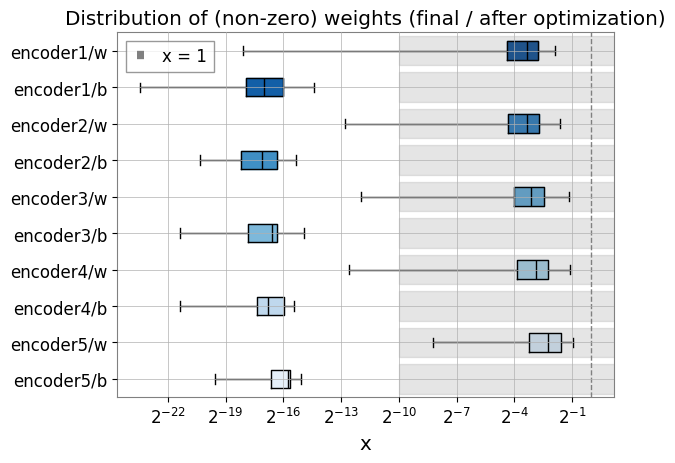

In [8]:
# Profiling

# Define a minimal model to explore the profiling method
profiling_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=profiling_config
)

# Run the numerical profiling
prof = numerical(model=model, hls_model=profiling_model)

# Bonus:
# To also see the layers' Activation Functions bit representation:
#  - activate tracing in the layers
#  - pass the input data to the numerical() methos

#for layer in profiling_config['LayerName'].keys():
#    profiling_config['LayerName'][layer]['Trace'] = True

#prof = numerical(model=model, hls_model=profiling_model, X=X_test)

**Excercise:**
- Adjust the weights and biases of the layers
- Re-run the profiling to check if the new definition is correct
- Repeat iteratively untill you are satisfied with the config

Hint: to update the layer you have to modify the profiling config, which is still a python dictionary...

**Questions:**
1. Do you remember the `ap_fixed` notation?
2. Will the optimized model use more or less resources with respect the "deafult config"?

In [10]:
# Compare performances with previous models
# ==== Adjust all the precisions ====
# Weights
profiling_config["LayerName"]["encoder1"]["Precision"]["weight"] = "ap_fixed<11,0>"
profiling_config["LayerName"]["encoder2"]["Precision"]["weight"] = "ap_fixed<11,0>"
profiling_config["LayerName"]["encoder3"]["Precision"]["weight"] = "ap_fixed<12,1>"
profiling_config["LayerName"]["encoder4"]["Precision"]["weight"] = "ap_fixed<11,1>"
profiling_config["LayerName"]["encoder5"]["Precision"]["weight"] = "ap_fixed<11,1>"

# Biases
profiling_config["LayerName"]["encoder1"]["Precision"]["bias"] = "ap_fixed<19,0>"
profiling_config["LayerName"]["encoder2"]["Precision"]["bias"] = "ap_fixed<19,0>"
profiling_config["LayerName"]["encoder3"]["Precision"]["bias"] = "ap_fixed<19,0>"
profiling_config["LayerName"]["encoder4"]["Precision"]["bias"] = "ap_fixed<19,0>"
profiling_config["LayerName"]["encoder5"]["Precision"]["bias"] = "ap_fixed<19,0>"

# Activations
profiling_config["LayerName"]["encoder1_tanh"]["Precision"]["result"] = "ap_fixed<9,1>"
profiling_config["LayerName"]["encoder2_tanh"]["Precision"]["result"] = "ap_fixed<9,1>"
profiling_config["LayerName"]["encoder3_tanh"]["Precision"]["result"] = "ap_fixed<9,1>"
profiling_config["LayerName"]["encoder4_tanh"]["Precision"]["result"] = "ap_fixed<9,1>"
profiling_config["LayerName"]["encoder5_tanh"]["Precision"]["result"] = "ap_fixed<9,1>"

# Main config
main_cfg = hls4ml.converters.create_config(
    board = 'alveo-u55c',            # Target boad and FPGA part
    part = 'xcu55c-fsvh2892-2L-e',   #
    clock_period = 3,                # Clock period in ns -> 3 ns = ~333 MHz
    backend = 'VivadoAccelerator'    # Backend to convert NN -> firmware
)

# Few more customizations
main_cfg['HLSConfig'] = profiling_config
main_cfg['IOType'] = 'io_parallel'
main_cfg['AcceleratorConfig']['Platform'] = 'xilinx_u55c_gen3x16_xdma_3_202210_1'
main_cfg['KerasModel'] = model
main_cfg['OutputDir'] = "small_model/small_encoder_profiled"

print("="*20, "Main Config", "="*20)
print_dict(main_cfg)
print("="*50)

# Define the hls model
profiled_model = hls4ml.converters.keras_v2_to_hls(main_cfg)

# Compile it
profiled_model.compile()

# Run inference
y_profiled = profiled_model.predict(X_test)

# Save predictions for later comparisons
np.save('y_profiled.npy', y_profiled)
print("Profiled config predictions saved as 'y_profiled.npy'.")

==================== Main Config ====================
OutputDir:           small_model/small_encoder_profiled
ProjectName:         myproject
Backend:             VivadoAccelerator
Version:             1.0.0
Part:                xcu55c-fsvh2892-2L-e
ClockPeriod:         3
ClockUncertainty:    12.5%
IOType:              io_parallel
HLSConfig
  Model
    Precision
      default:       fixed<16,6>
    ReuseFactor:     1
    Strategy:        Latency
    BramFactor:      1000000000
    TraceOutput:     False
    BitExact:        None
  LayerName
    flatten_input
      Trace:         False
      Precision
        result:      auto
    flatten
      Trace:         False
      Precision
        result:      auto
    encoder1
      Trace:         False
      Precision
        result:      auto
        weight:      ap_fixed<11,0>
        bias:        ap_fixed<19,0>
    encoder1_tanh
      Trace:         False
      Precision
        result:      ap_fixed<9,1>
    encoder2
      Trace:         Fa


=== Software vs Profiled Reconstruction Metrics ===
Overall MSE           : 0.000909
Average MSE per sample: 0.000909
Min MSE               : 0.000254
Max MSE               : 0.002743
Mean Absolute Error   : 0.024001
RMSE                  : 0.030155

Comparison plot saved as 'cpu_hls_profiled_comparison.png'
Error distribution plot saved as 'profiled_error_distribution.png'


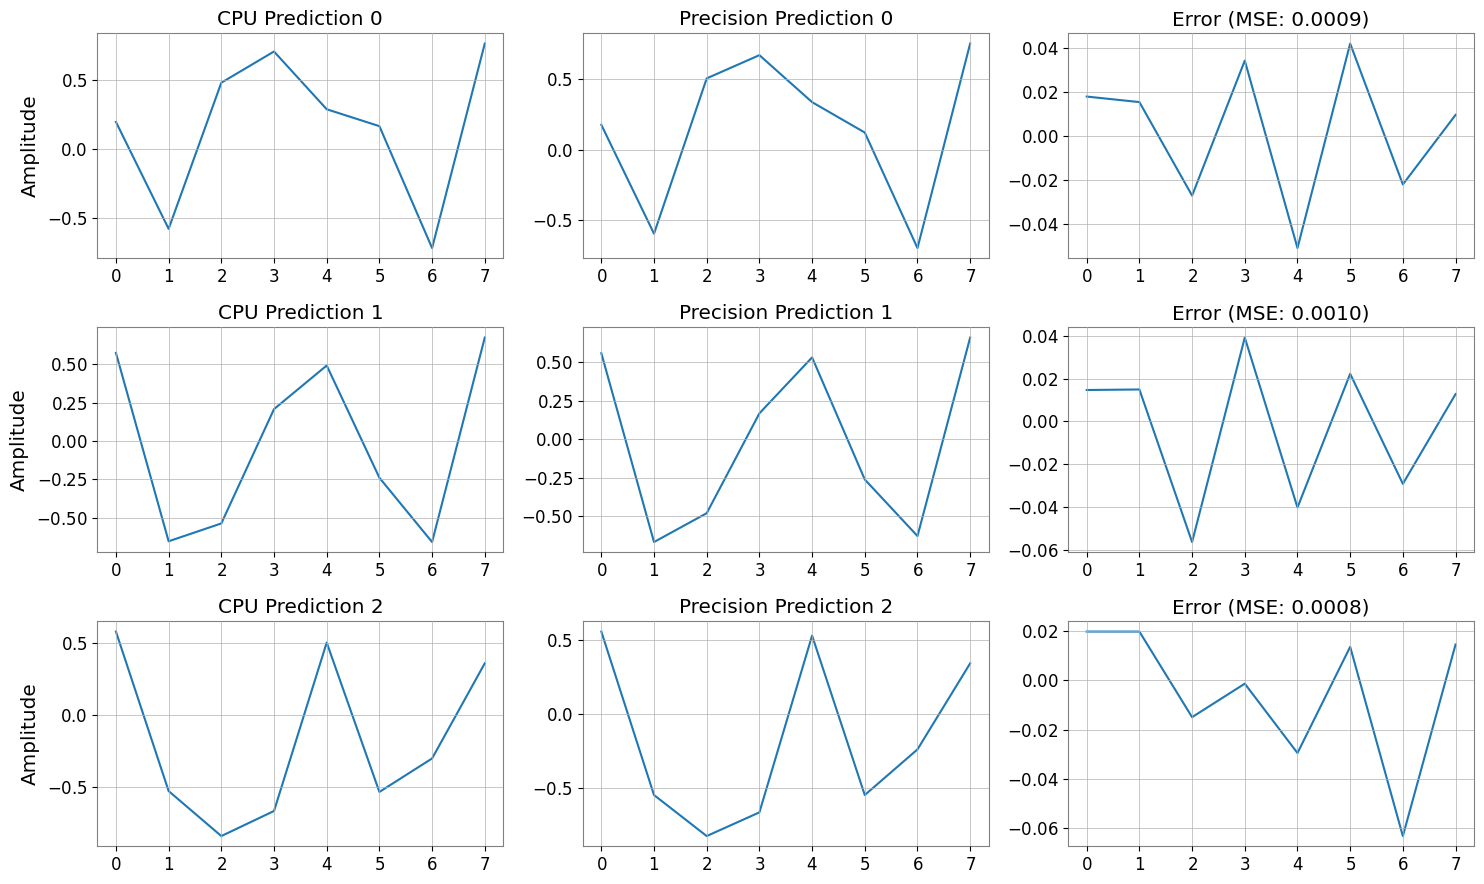

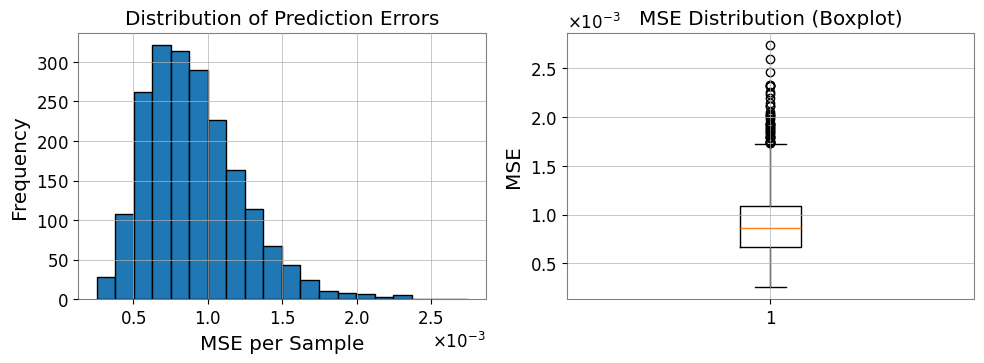

In [11]:
# Calculate and visualize comparison metrics

# Load the previously saved inferences
y_cpu = np.load("y_cpu.npy")

# MSE per sample: mean squared error for each sample across all features
mse_per_sample = np.mean((y_cpu - y_profiled)**2, axis=1)

# Overall MSE: average of all MSE values
overall_mse = np.mean(mse_per_sample)

# MAE: mean absolute error across all predictions
mae = np.mean(np.abs(y_cpu - y_profiled))

# RMSE: square root of overall MSE
rmse = np.sqrt(overall_mse)

# Print the metrics
print(f"\n=== Software vs Profiled Reconstruction Metrics ===")
print(f"Overall MSE           : {overall_mse:.6f}")
print(f"Average MSE per sample: {np.mean(mse_per_sample):.6f}")
print(f"Min MSE               : {np.min(mse_per_sample):.6f}")
print(f"Max MSE               : {np.max(mse_per_sample):.6f}")
print(f"Mean Absolute Error   : {mae:.6f}")
print(f"RMSE                  : {rmse:.6f}")

# Visualize comparison for first 3 samples (no changes needed)
n_examples = 3
fig, axes = plt.subplots(n_examples, 3, figsize=(15, 3*n_examples))

for i in range(n_examples):
    # CPU predictions
    axes[i, 0].plot(y_cpu[i])
    axes[i, 0].set_title(f'CPU Prediction {i}')
    axes[i, 0].set_ylabel('Amplitude')
    axes[i, 0].grid(True)
    
    # HLS predictions
    axes[i, 1].plot(y_profiled[i])
    axes[i, 1].set_title(f'Precision Prediction {i}')
    axes[i, 1].grid(True)
    
    # Difference
    axes[i, 2].plot(y_cpu[i] - y_profiled[i])
    axes[i, 2].set_title(f'Error (MSE: {mse_per_sample[i]:.4f})')
    axes[i, 2].grid(True)

plt.tight_layout()
plt.savefig('cpu_hls_comparison.png')
print("\nComparison plot saved as 'cpu_hls_profiled_comparison.png'")

# Visualize error distribution (no changes needed)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(mse_per_sample, bins=20, edgecolor='black')
plt.xlabel('MSE per Sample')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot(mse_per_sample)
plt.ylabel('MSE')
plt.title('MSE Distribution (Boxplot)')
plt.grid(True)

plt.tight_layout()
plt.savefig('profiled_error_distribution.png')
print("Error distribution plot saved as 'profiled_error_distribution.png'")

### Bonus - Tracing
Use the "Trace" method to collect the model outputs at each layer and identify if/where a too aggressive bit-representation was applied:

In [ ]:
## Get HLS predictions and trace
#hls4ml_pred, hls4ml_trace = profiled_model.trace(X_test[:1000])
#
## Get trace from keras using get_ymodel_keras
#keras_trace = get_ymodel_keras(model, X_test[:1000])
#
## Print and compare
#print("Keras layer 'encoder1', first sample:")
#print(keras_trace['encoder1'][0])
#print("hls4ml layer 'encoder1', first sample:")
#print(hls4ml_trace['encoder1'][0])

### Task 2.3: Other Model Optimizations
There are other "Model-Level" optimization parameters that you can explore:
- `Strategy`: refers to the implementation of core matrix-vector multiplication routine, which can be latency-oriented, resource-saving oriented, or specialized.
  - Possible values: `"Latency"`, `"Resource"` 
- `ReuseFactor`: this defines the pipeline interval or initiation interval, i.e. how many times each resource can/will be re-used in the implementation
  - The ReuseFactor can also be defined on a per-layer base
  - Possible values: powers of `2`
- `BramFactor`: Contols which layers will be implemented as BRAM elements
  - Example: setting `BramFactor=100`, only layers with more than 100 weights will be exposed as external BRAM.

All these parameters are usually customized together to get to the desired firmware implementation.

In [13]:
# Explore the Strategy/ReuseFactor/BramFactor parameters

RF_config = hls4ml.utils.config_from_keras_model(model, granularity='model')
RF_config['Model']['ReuseFactor'] = 8

# Main config
main_cfg = hls4ml.converters.create_config(
    board = 'alveo-u55c',            # Target boad and FPGA part
    part = 'xcu55c-fsvh2892-2L-e',   #
    clock_period = 3,                # Clock period in ns -> 3 ns = ~333 MHz
    backend = 'VivadoAccelerator'    # Backend to convert NN -> firmware
)

# Few more customizations
main_cfg['HLSConfig'] = RF_config                                                 # our model config
main_cfg['IOType'] = 'io_parallel'                                                # I/O control
main_cfg['AcceleratorConfig']['Platform'] = 'xilinx_u55c_gen3x16_xdma_3_202210_1' # Platform part
main_cfg['KerasModel'] = model                                                    # keras encoder
main_cfg['OutputDir'] = 'small_model/small_encoder_RF8'                           # output directory

# And print it
print("="*20, "Main Config", "="*20)
print_dict(main_cfg)
print("="*50)

# Define the hls model
RF_model = hls4ml.converters.keras_v2_to_hls(main_cfg)

# Compile it
RF_model.compile()

==================== Main Config ====================
OutputDir:           small_model/small_encoder_RF8
ProjectName:         myproject
Backend:             VivadoAccelerator
Version:             1.0.0
Part:                xcu55c-fsvh2892-2L-e
ClockPeriod:         3
ClockUncertainty:    12.5%
IOType:              io_parallel
HLSConfig
  Model
    Precision
      default:       fixed<16,6>
    ReuseFactor:     8
    Strategy:        Latency
    BramFactor:      1000000000
    TraceOutput:     False
WriterConfig
  Namespace:         None
  WriteWeightsTxt:   True
  WriteTar:          False
  TBOutputStream:    both
AcceleratorConfig
  Board:             alveo-u55c
  Interface:         axi_stream
  Driver:            python
  Precision
    Input:           float
    Output:          float
  Platform:          xilinx_u55c_gen3x16_xdma_3_202210_1
KerasModel:          <keras.src.engine.sequential.Sequential object at 0x7ff23ade7520>


## Part 4: Check Resources
So far, we have only checked how the accuracy of the translated model was, but a crucial point of optimizing the HLS configs is ensuring that we can fit our model into the FPGA resources and that it is running fast enough!  

**Exercise**
Choose a few of the models you explored above and run the synthesis.

In [14]:
# Run the synthesys
RF_model.build(csim=False)

# Print the reports
print("Resource usage and latency:")
print_report('autoencoder/hls4ml_small_encoder_RF8')


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2023.2 (64-bit)
  **** SW Build 4023990 on Oct 11 2023
  **** IP Build 4028589 on Sat Oct 14 00:45:43 MDT 2023
  **** SharedData Build 4025554 on Tue Oct 10 17:18:54 MDT 2023
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2023 Advanced Micro Devices, Inc. All Rights Reserved.

source /opt/tools/Xilinx/Vitis_HLS/2023.2/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/opt/tools/Xilinx/Vitis_HLS/2023.2/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'fbrivio' on host '0a14f8543b53' (Linux_x86_64 version 5.4.0-169-generic) on Sat Nov 22 21:05:13 UTC 2025
INFO: [HLS 200-10] On os Ubuntu 24.04.2 LTS
INFO: [HLS 200-10] In directory '/home/fbrivio/hackathon/small_model/small_encoder_RF8'
INFO: [HLS 200-2053] The vitis_hls executable is being deprecated. Consider using vitis-run --mode hls --tcl
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_pr